ARIMA  model on the outbound data by weeks

Step 0: Explore the dataset

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import openpyxl
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

#  ARIMA model  to forecast the weekly number of pallets at the outbound
# ARIMA(p,d,q)

In [2]:
# Provide the correct file path if necessary
excel_file = 'OUtbound.xlsx'

try:
    # Read the Excel file with optional parameters
    df = pd.read_excel(excel_file, parse_dates=['date'], index_col='date')

    # Print information about the DataFrame
    df.info()

except Exception as e:
    print(f"An error occurred: {e}")


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 261 entries, 2022-08-01 to 2023-07-28
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   ordered_pallets  261 non-null    int64
dtypes: int64(1)
memory usage: 4.1 KB


In [3]:
df.head()

,ordered_pallets
date,
2022-08-01,74
2022-08-02,98
2022-08-03,200
2022-08-04,129
2022-08-05,84


**step 2 :resample**
 Aggregate of data
  Daily to  weekly

In [4]:
ts= df['ordered_pallets'].resample('W').sum()

In [5]:
ts.head()

date
2022-08-07    585
2022-08-14    742
2022-08-21    605
2022-08-28    608
2022-09-04    556
Freq: W-SUN, Name: ordered_pallets, dtype: int64

<Axes: xlabel='date'>

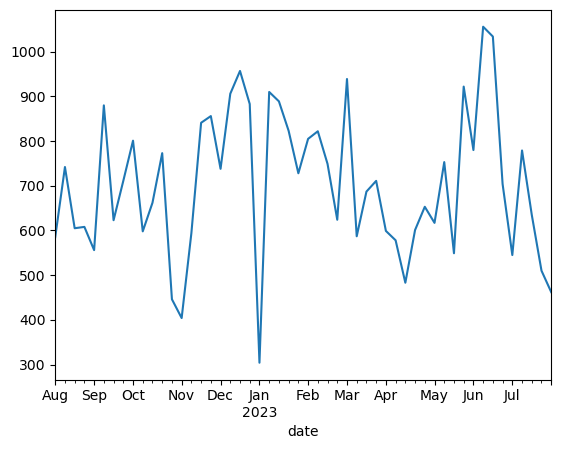

In [6]:
ts.plot()

# Step 3: Stationarity check

In [7]:
import statsmodels.api as sm

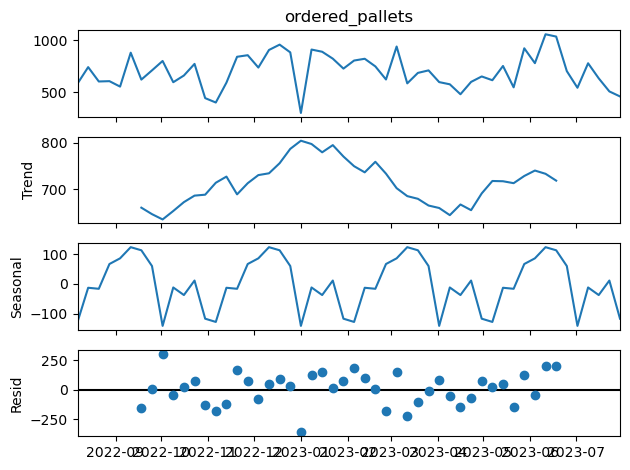

In [8]:
decomposition = sm.tsa.seasonal_decompose(ts, model= 'additive', period= 13)
fig = decomposition.plot()
plt.show()

In [9]:
adftest= adfuller(ts)


In [10]:
print('pvalue of adfuller test is: ', adftest[1])

pvalue of adfuller test is:  1.9391901963801924e-06


Hence our time series is stationary 

# train - test split of our data

In [11]:
len(ts)

52

In [12]:
train=ts[:43]
test=ts[43:]

# ARIMA MODEL BUILDING   ARIMA(p,d,q)

WORKS FOR NON SEASONAL TIME SERIES DATA


AR =  regression of the data with respect to the past periods

p= the order of the  past periods
P from PACF plots

MA =  includes the past  errors of the AR model into our present prediction

q = How many errors  to include in our model
q from ACF plots

I = intergrated
diference the data to remove trend and seasonality to make it stationary

d = the order:  how many times we difference the data

#  Methods to determine p, d, q

1. classical method: Using ACF PACF plots
2. Auto_ARIMA Function
3. For loop

# Using the for loop

In [13]:
import itertools

In [14]:
p=range(0,9)
q=range(0,9)
d=range(0,2)

In [15]:
pdq_combination = list(itertools.product(p,d,q))

In [16]:
len(pdq_combination)

162

In [17]:
rmse=[]
order1=[]

In [18]:
for pdq in pdq_combination:
    try:
        model = ARIMA(train, order=pdq).fit()
        pred= model.predict(start=len(train), end= (len(ts)-1))
        error= np.sqrt(mean_squared_error(test, pred))
        order1.append(pdq)
        rmse.append(error)
    except:
        continue

In [19]:
result = pd.DataFrame(index=order1, data=rmse,columns=['RMSE'])

In [20]:
result.to_csv('ARIMAcombi.csv')

from the Result, we see that an ARIMA(1,0,5) has the smallest RMSE

# ARIMA  model Building

In [21]:
model = ARIMA(train, order = (8,1,3)).fit()

# step 7:  predict test data

In [22]:
len(train),(len(ts)-1)

(43, 51)

Building a dataset equal to our test data and predicting the ordered pallets for the following weeks

In [23]:
pred = model.predict(start=len(train), end=(len(ts)-1))

In [24]:
pred.head()

2023-06-04    684.045561
2023-06-11    772.521600
2023-06-18    710.305798
2023-06-25    704.641676
2023-07-02    737.146413
Freq: W-SUN, Name: predicted_mean, dtype: float64

# Model Evaluation

based on the predicted values, we can evaluate our model

In [25]:
from sklearn.metrics import mean_squared_error

using the mean square error to eavaluate our model

In [26]:
error = np.sqrt(mean_squared_error(test,pred))
error

196.3921079228729

finding the mean value of the test dataset to compare with the predicted value to see if our parameters 
lies within 1 standard deviation of the mean

In [27]:
test.mean(), np.sqrt(test.var())

(722.7777777777778, 214.26430977753725)

<Axes: xlabel='date'>

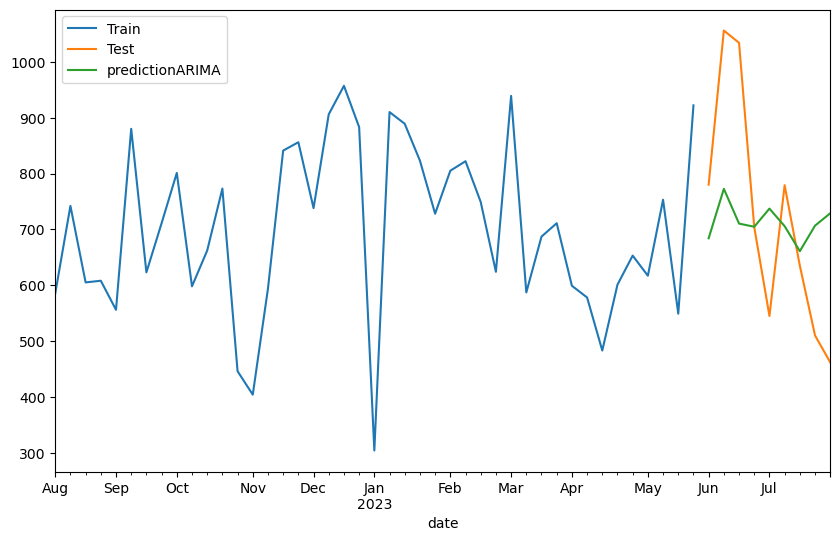

In [28]:
train.plot(legend=True, label ='Train', figsize= ( 10,6))
test.plot(legend=True, label= 'Test')
pred.plot(legend= True, label='predictionARIMA')

# Step 9:  Predict future ordered pallets

In [126]:
pred.to_csv('testpred1_0_5.csv')
test.to_csv('test.csv')

we now use the complete dataset 
we will be predicting the next 4 weeks 
so as to reduce prediction errors

In [127]:
final_model= ARIMA(ts, order= (5,0,1)).fit()  # build on the full dataset

In [128]:
prediction= final_model.predict(len(ts),len(ts)+4)

<Axes: xlabel='date'>

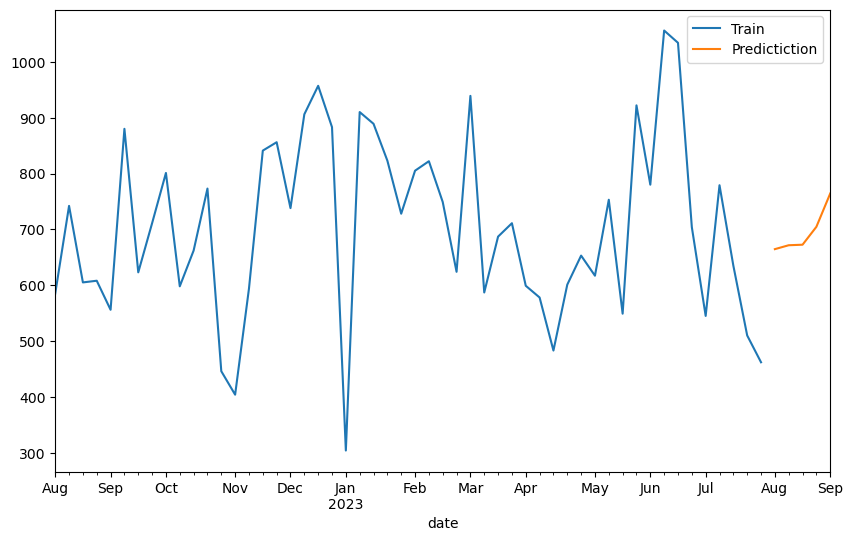

In [129]:
ts.plot(legend=True, label = 'Train', figsize=(10,6))
prediction.plot(legend=True, label='Predictiction')

# Seeing the actual prediction results

In [115]:
prediction.head()

2023-08-06    664.560529
2023-08-13    671.549514
2023-08-20    672.503424
2023-08-27    704.537240
2023-09-03    764.181591
Freq: W-SUN, Name: predicted_mean, dtype: float64

In [116]:
predictions = pd.DataFrame(data=prediction,columns=['Prediction'])
prediction.to_csv('prediction5_0_1.csv')

#  If we agree on this, then I can do it for the daily  and for  the other 2 departments as well. inbound and inbound frigo

Because our datasets did not have any seasonality or trend, I didn't look at **SARIMA**